# Dependencies

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import os
import glob
from matplotlib.pylab import rcParams

# Help Functions

In [2]:
def imshow(image, cmap=None):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [3]:
def motion_blur(image):
    # blurr size
    kernel_size = 110

    # Create the vertical kernel. 
    kernel_v = np.zeros((kernel_size, kernel_size)) 

    # Create a copy of the same for creating the horizontal kernel. 
    kernel_h = np.copy(kernel_v) 

    # Fill the middle row with ones. 
    kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size) 
    kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size) 

    # Normalize. 
    kernel_v /= kernel_size 
    kernel_h /= kernel_size 

    # Apply the vertical kernel. 
    ver = cv2.filter2D(image, -1, kernel_v)

    # Apply the horizontal kernel. 
    hor = cv2.filter2D(image, -1, kernel_h) 

    # Apply both
    both = cv2.filter2D(ver, -1, kernel_h)


    return ver, hor, both

In [4]:
def find_vehicle(both):
    
    # threshold
    ret,thresh = cv2.threshold(both.copy(), 2, 255, cv2.THRESH_BINARY)

    # find the contours of the thresholded image
    (cnts, _) = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    srt_cnts = sorted(cnts, key = cv2.contourArea, reverse = True) # reverse -- true for decending
    
    if cv2.contourArea(srt_cnts[0]) <= 100000:
        [x,y,w,h] = cv2.boundingRect(srt_cnts[0])
        
        # draw rectangle around contour on original image
        best_contour = cv2.rectangle(image.copy(),(x,y),(x+w+20,y+h+50), (255,0,255), 2)
        
    else:
        # threshold
        ret,thresh = cv2.threshold(both.copy(), 3, 255, cv2.THRESH_BINARY)

        # find the contours of the thresholded image
        (cnts, _) = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        srt_cnts = sorted(cnts, key = cv2.contourArea, reverse = True) # reverse -- true for decending
        
        [x,y,w,h] = cv2.boundingRect(srt_cnts[0])
        # draw rectangle around contour on original image
        best_contour = cv2.rectangle(image.copy(),(x,y),(x+w+20,y+h+50),(255,0,255),2)
    #print(f'the area of the contour is {cv2.contourArea(srt_cnts[0])}')
    
    return thresh, best_contour, x,y,w,h

In [22]:
def find_plate(hist_equal):
    
    blur = cv2.GaussianBlur(hist_equal, (5, 5), 0)
    #canny_edges = cv2.Canny(blur, 225, 250)


    #thresh = cv2.inRange(blur.copy(), 180, 256)
    #thresh = cv2.adaptiveThreshold(blur.copy(), 250, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 5, 5)
    #(_,thresh) = cv2.threshold(blur.copy(), 250, 255,cv2.THRESH_BINARY)
    (_,thresh) = cv2.threshold(blur.copy(), 150, 255,cv2.THRESH_BINARY)
    #(_,thresh) = cv2.threshold(blur.copy(), 105, 255,cv2.THRESH_BINARY) 
    #(_,thresh) = cv2.threshold(blur.copy(), 80, 255,cv2.THRESH_BINARY) 
    #(_,thresh) = cv2.threshold(blur.copy(), 60, 255,cv2.THRESH_BINARY) 
    #(_,thresh) = cv2.threshold(blur.copy(), 40, 255,cv2.THRESH_BINARY) 
    
    
    # find the contours of the thresholded image
    (cnts, _) = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    srt_cnts = sorted(cnts, key = cv2.contourArea, reverse = True) # reverse -- true for decending

    # find the aspect ratio of each of the four largest contours to eliminate any with the wrong shape
    # remove contour that is line (w or h is 1)
    bestContour = []
    for (i,c) in enumerate(srt_cnts):

        (x,y,w,h) = cv2.boundingRect(c)
        aspectRatio = w / float(h)
        if 1.7 <= aspectRatio <= 3 and w != 1 and h != 1 and cv2.contourArea(c) > 10 and cv2.contourArea(c) < 2000 and len(bestContour) < 3:

            bestContour.append(srt_cnts[i])
            #break
        else:
            pass


    #len(bestContour)
    #bestContour

    copied = cropped.copy()
    
    for contour in bestContour:
        # get rectangle bounding contour
        [x,y,w,h] = cv2.boundingRect(contour)

        # draw rectangle around contour on original image
        best_contour = cv2.rectangle(copied,(x-30,y-10),(x+w+30,y+h+5),(255,17,25),2)
        #test = cv2.rectangle(copied,(x,y),(x+w,y+h),(255,17,25),2)
        
    
    [x,y,w,h] = cv2.boundingRect(bestContour[0])    
    best_contour = cv2.rectangle(copied,(x-30,y-10),(x+w+30,y+h+5),(0,255,0),2)
    
    
    return best_contour, x,y,w,h

In [6]:
def crop_vehicle(image,x,y,w,h):
    cropped = image[y:y+h+50,x:x+w+20]
    return cropped

In [7]:
def crop_plate(image,x,y,w,h):
    cropped = image[y-10:y+h+5,x-30:x+w+30]
    return cropped

In [8]:
def histogram_equalizer(image):
    grayed_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ## CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit= 10.0, tileGridSize=(8,8))
    cl1 = clahe.apply(grayed_image)
    
    return cl1

# Overall Process

In [9]:
image_path = 'D:\\OneDrive - Georgia State University\\MSA\\Fall 2019\\MSA 8650 - Image and Text Analytics with Deep Neural Networks\\Assignments\\Assignment 1\\Results\\Segments\\'

In [10]:
number = 4
data_list = [f for f in listdir(image_path) if isfile(join(image_path, f))]

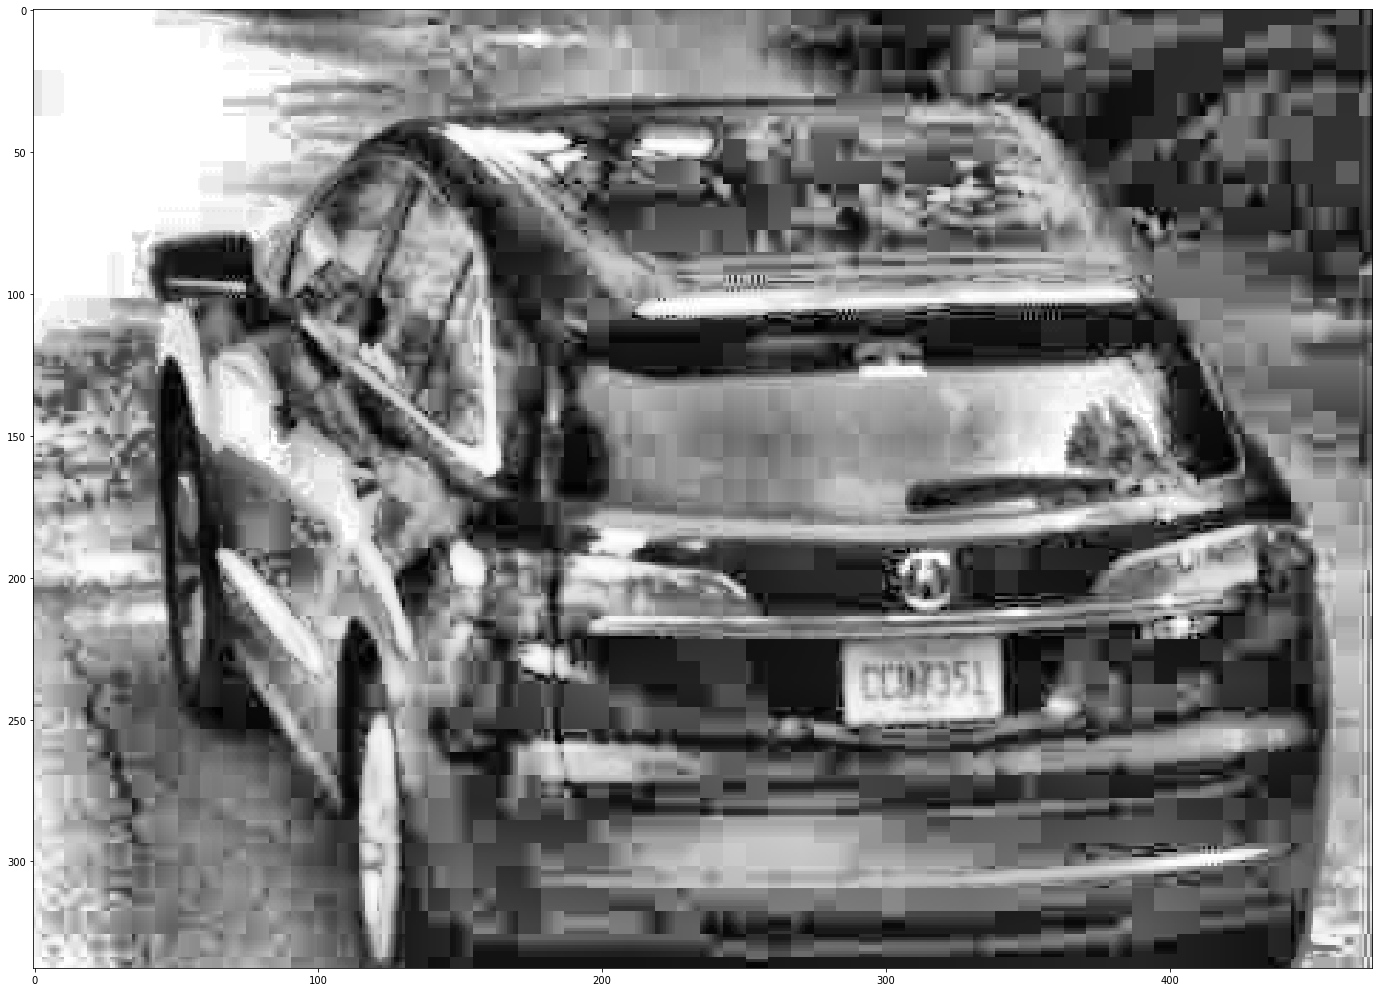

In [28]:
image = cv2.imread(image_path + data_list[number]) 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
canny_edges = cv2.Canny(blurred, 225, 250)
hor, ver, both = motion_blur(canny_edges)
thresh, best_contour,x,y,w,h = find_vehicle(both)
cropped = crop_vehicle(image, x,y,w,h)


hist_equal = histogram_equalizer(cropped)


rcParams['figure.figsize'] = 24,24
imshow(hist_equal)

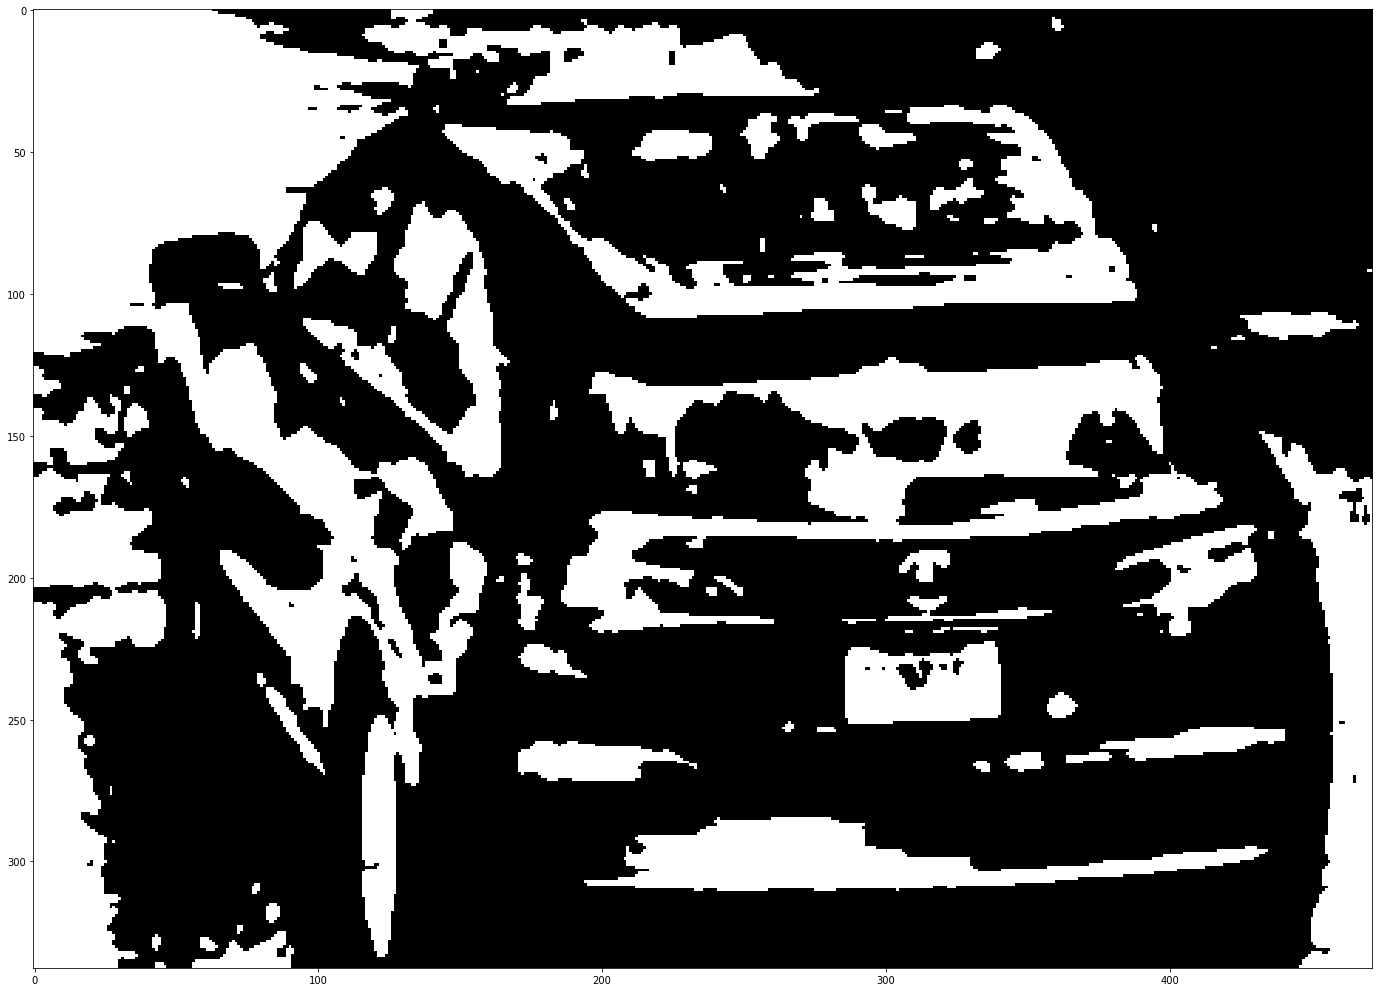

In [29]:
blur = cv2.GaussianBlur(hist_equal, (5, 5), 0)
#canny_edges = cv2.Canny(blur, 225, 250)


#thresh = cv2.inRange(blur.copy(), 180, 256)
#thresh = cv2.adaptiveThreshold(blur.copy(), 250, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 5, 5)
#(_,thresh) = cv2.threshold(blur.copy(), 250, 255,cv2.THRESH_BINARY)
(_,thresh) = cv2.threshold(blur.copy(), 150, 255,cv2.THRESH_BINARY)
#(_,thresh) = cv2.threshold(blur.copy(), 105, 255,cv2.THRESH_BINARY) 
#(_,thresh) = cv2.threshold(blur.copy(), 80, 255,cv2.THRESH_BINARY) 
#(_,thresh) = cv2.threshold(blur.copy(), 60, 255,cv2.THRESH_BINARY) 
#(_,thresh) = cv2.threshold(blur.copy(), 40, 255,cv2.THRESH_BINARY) 

plt.imshow(thresh, cmap='gray')

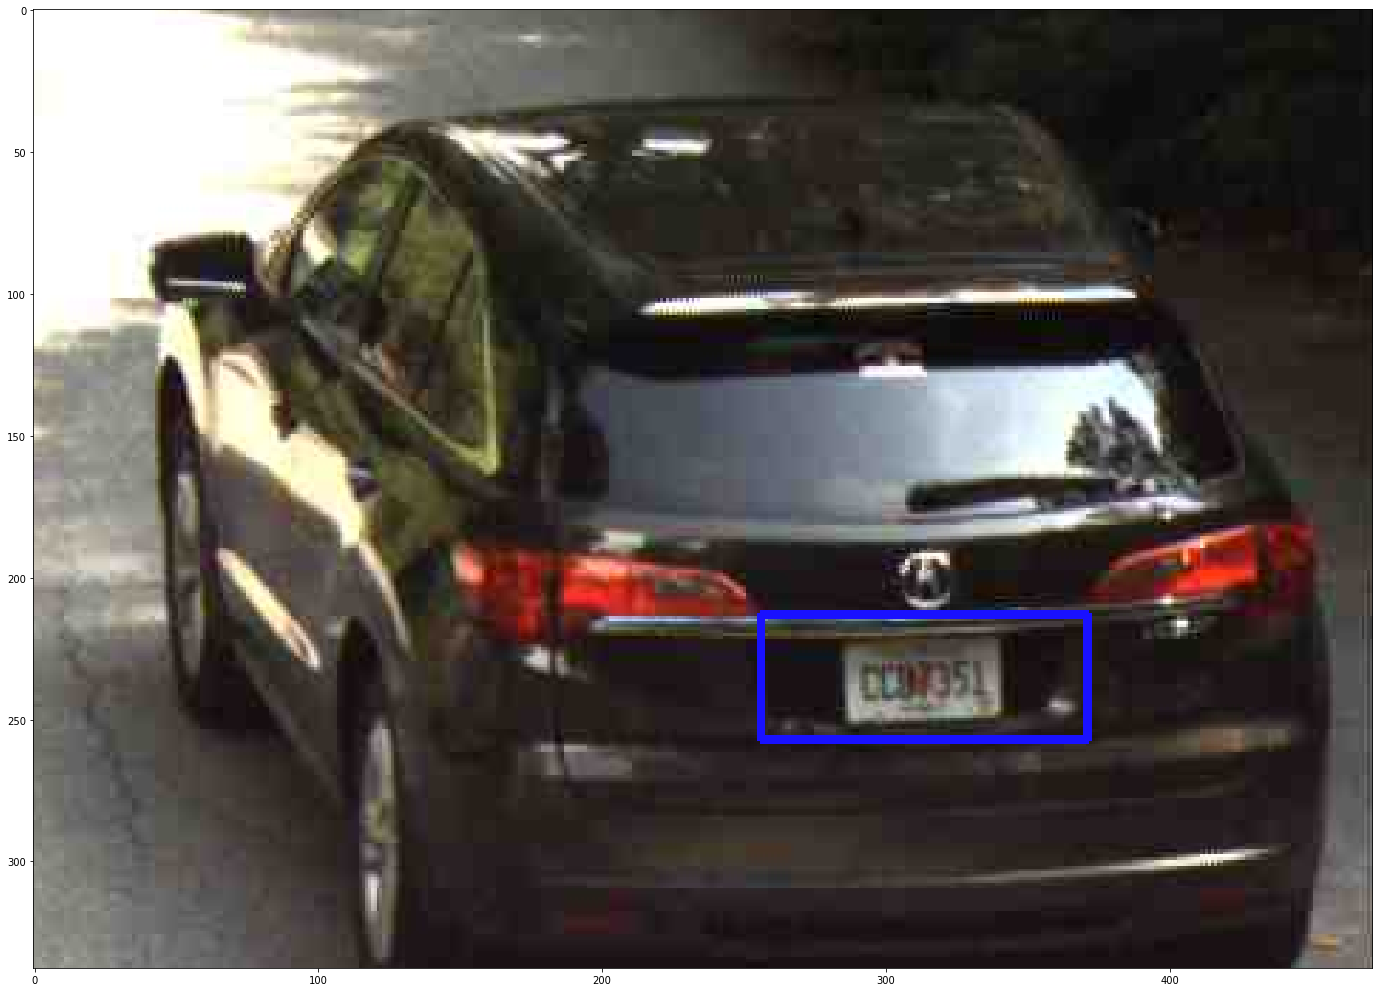

In [31]:
# find the contours of the thresholded image
(cnts, _) = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
srt_cnts = sorted(cnts, key = cv2.contourArea, reverse = True) # reverse -- true for decending

# find the aspect ratio of each of the four largest contours to eliminate any with the wrong shape
# remove contour that is line (w or h is 1)
bestContour = []
for (i,c) in enumerate(srt_cnts):

    (x,y,w,h) = cv2.boundingRect(c)
    aspectRatio = w / float(h)
    if 1.7 <= aspectRatio <= 3 and w != 1 and h != 1 and cv2.contourArea(c) > 10 and cv2.contourArea(c) < 2000 and len(bestContour) < 5:

        bestContour.append(srt_cnts[i])
        break
    else:
        pass


len(bestContour)
#bestContour

copied = cropped.copy()

for contour in bestContour:
    # get rectangle bounding contour
    [x,y,w,h] = cv2.boundingRect(contour)

    # draw rectangle around contour on original image
    test = cv2.rectangle(copied,(x-30,y-10),(x+w+30,y+h+5),(255,17,25),2)
    #test = cv2.rectangle(copied,(x,y),(x+w,y+h),(255,17,25),2)
    
imshow(test)
    

In [32]:
img_height, img_width = 600, 800

# Run on a batch

In [13]:
# set the saving directory to specified path 

result_path = 'D:\\OneDrive - Georgia State University\\MSA\\Fall 2019\\MSA 8650 - Image and Text Analytics with Deep Neural Networks\\Assignments\\Assignment 1\\Results\\'

Plates_path = result_path + 'Plates\\'

In [34]:
image_path = 'D:\\OneDrive - Georgia State University\\MSA\\Fall 2019\\MSA 8650 - Image and Text Analytics with Deep Neural Networks\\Assignments\\Assignment 1\\Data\\context\\'
data_list = [f for f in listdir(image_path) if isfile(join(image_path, f))]
#data_list = sorted(data_list, key=lambda x: float(x.split('.')[0]))

count = 0
for i in data_list:
    #x = np.zeros([img_height,img_width])+255
    #cv2.imwrite(f'{Plates_path}{count}.png', x)
    try:
        image = cv2.imread(image_path + i) 
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        canny_edges = cv2.Canny(blurred, 225, 250)
        hor, ver, both = motion_blur(canny_edges)
        thresh, best_contour, x,y,w,h = find_vehicle(both)
        cropped = crop_vehicle(image, x,y,w,h)
        hist_equal = histogram_equalizer(cropped)
        best_plate, x,y,w,h = find_plate(hist_equal)
        plate = crop_plate(best_plate,x,y,w,h)

        cv2.imwrite(f'{Plates_path}{count}.png', best_plate)
    except:
        print(count)
    
    count += 1
    

51
52
54
56
380
383
385
386
389
708
712
716
717
723
760
762
763
768
773
1119
1122
1138
1140
1146
1147
1151
1153
1154
1155
1158
1159
1583
1586
1590
